This notebook was ran on a Google Cloud Workbench jupyter notebook instance with a Free Tier n2-highmem-8 (8 vCPUs, 64GB RAM) machine.

# Results

In [1]:
%cd /home/jupyter
!pip install -r requirements.txt
%cd /home/jupyter/notebooks

/home/jupyter
/home/jupyter/notebooks


In [2]:
import warnings
warnings.filterwarnings('ignore')

import logging
logging.getLogger().setLevel(logging.ERROR)

In [3]:
from google.cloud import bigquery
import pandas
import json
import time
tops = [5, 10, 20]

with open('/home/jupyter/setup.json', 'r') as file :
    variables = json.load(file)

if variables["USE_GCP"] != "false":
    bq_client = bigquery.Client(
        project = variables['PROJECT_ID'], 
        location = variables['REGION']
    )

In [4]:
try:
    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk import ngrams

    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    remove_words = stopwords.words()
except:
    import nltk
    nltk.download('stopwords')
    nltk.download('punkt')

    from nltk.stem.porter import PorterStemmer
    from nltk.tokenize import RegexpTokenizer
    from nltk.corpus import stopwords
    from nltk import ngrams

    stemmer = PorterStemmer()
    tokenizer = RegexpTokenizer(r'\w+')
    remove_words = stopwords.words()

def tosplit(x):
    if x is None:
        return []
    else:
        return str(x).split(';')

In [6]:
if variables["USE_GCP"] != "false":
    sql = f"""WITH results AS (SELECT DISTINCT * FROM `{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_PREDICTIONS_ID']}` as input
    JOIN `{variables['PROJECT_ID']}.{variables['DATASET_ID']}.{variables['TABLE_OUTPUT_ID']}` as output
    ON (input.dataset_id = output.dataset_id AND input.text_id = output.text_id)) 
    SELECT * FROM results ORDER BY 1, 2, 3, 4
    """
    predictions = bq_client.query(sql).to_dataframe()[['model_id', 'dataset_id', 'text_id', 'subset_id', 'output'] + [f'predictions_{top}' for top in tops]]
else:
    predictions = pandas.read_csv(f"{variables['TABLE_PREDICTIONS_ID']}.csv", sep=',').merge(pandas.read_csv(f"{variables['TABLE_OUTPUT_ID']}.csv", sep=','), how='left')

predictions['output'] = predictions['output'].apply(lambda x : [''.join([stemmer.stem(subword) for subword in tokenizer.tokenize(word)]) for word in tosplit(x)])

for top in tops :
    predictions.loc[predictions[f'predictions_{top}'].apply(lambda x : x is None), f'predictions_{top}'] = ''
    predictions[f'predictions_{top}'] = predictions[f'predictions_{top}'].apply(lambda x : [''.join([stemmer.stem(subword) for subword in tokenizer.tokenize(word)]) for word in str(x).split(';')])
    predictions[f'correct_{top}'] = predictions.apply(lambda x : sum([prediction in x['output'] for prediction in x[f'predictions_{top}']]), axis = 1)
    predictions[f'incorrect_{top}'] = predictions.apply(lambda x : sum([prediction not in x['output'] for prediction in x[f'predictions_{top}']]), axis = 1)
    predictions[f'missing_{top}'] = predictions.apply(lambda x : len(x['output']) - sum([prediction in x['output'] for prediction in x[f'predictions_{top}']]), axis = 1)
    predictions[f'macf1_{top}'] = predictions.apply(lambda x : 100 * x[f'correct_{top}'] / (x[f'correct_{top}'] + 0.5 * (x[f'incorrect_{top}'] + x[f'missing_{top}'])), axis = 1)
    
summed = predictions.groupby(['dataset_id', 'subset_id', 'model_id']).sum()
results = predictions.groupby(['dataset_id', 'subset_id', 'model_id']).mean()
for top in tops : 
    results[f'micf1_{top}'] = 100 * summed[f'correct_{top}'] / (summed[f'correct_{top}'] + 0.5 * (summed[f'incorrect_{top}'] + summed[f'missing_{top}']))

results[[f'micf1_{top}' for top in tops] + [f'macf1_{top}' for top in tops]]

micf1_5   micf1_10   micf1_20  \
dataset_id   subset_id    model_id                                              
inspec       controlled   MultipartiteRank     3.921983   3.890778   3.538472   
                          TfIdf                5.141198   5.265704   4.397674   
                          TopicRank            3.659633   3.468494   3.004445   
                          YAKE                 4.001056   4.699053   4.373554   
                          keyVD_controlled     6.944529   9.753862  11.184518   
                          keyVD_uncontrolled   1.426046   2.106929   2.258196   
             uncontrolled MultipartiteRank    21.011966  25.203294  27.308183   
                          TfIdf               13.710889  17.711914  19.210815   
                          TopicRank           20.328317  24.195844  25.273845   
                          YAKE                14.052466  17.462379  18.428258   
                          keyVD_controlled     1.579460   2.401394   2.982556   
                          keyVD_uncontrolled   8.387971  13.142341  16.769316   
semeval      author       MultipartiteRank    13.942752  11.458949   8.584285   
                          TfIdf               15.697138  13.703485   9.612084   
                          TopicRank           11.634349  10.162482   7.065889   
                          YAKE                14.219760  12.994684  10.298661   
                          keyVD_author         8.562368  13.001912  15.164835   
                          keyVD_reader         2.474227   3.222342   4.536862   
             reader       MultipartiteRank    12.125501  13.921964  14.469494   
                          TfIdf               11.087521  13.372413  12.887707   
                          TopicRank           11.134702  13.228289  12.438583   
                          YAKE                 9.624912  12.639678  13.697936   
                          keyVD_author         2.320303   4.052901   5.916331   
                          keyVD_reader         5.382507   9.247842  11.641554   
termith-eval indexer      MultipartiteRank    11.806798  13.909039  13.883005   
                          TfIdf               13.029219  14.845456  13.833399   
                          TopicRank           11.061419  12.677193  12.810802   
                          YAKE                 9.719738  12.432495  13.518855   
                          keyVD_indexer       10.713713  16.381055  20.690409   

                                                macf1_5   macf1_10   macf1_20  
dataset_id   subset_id    model_id                                             
inspec       controlled   MultipartiteRank     3.844113   3.742946   3.429335  
                          TfIdf                5.120502   5.110877   4.280312  
                          TopicRank            3.586733   3.334444   2.930768  
                          YAKE                 4.066502   4.661078   4.295701  
                          keyVD_controlled     7.069880   9.804534  11.250991  
                          keyVD_uncontrolled   1.430571   2.029021   2.219524  
             uncontrolled MultipartiteRank    21.942793  25.495713  27.286499  
                          TfIdf               15.106710  18.372666  19.303033  
                          TopicRank           21.206094  24.292874  25.240996  
                          YAKE                15.146569  18.020935  18.460851  
                          keyVD_controlled     1.779025   2.536666   3.122007  
                          keyVD_uncontrolled   8.880875  13.576203  17.183461  
semeval      author       MultipartiteRank    13.719511  11.227274   8.465719  
                          TfIdf               15.540709  13.448303   9.481929  
                          TopicRank           11.391232   9.915428   7.060253  
                          YAKE                14.345354  12.899811  10.222050  
                          keyVD_author         8.270781  12.887111  14.998071  
                

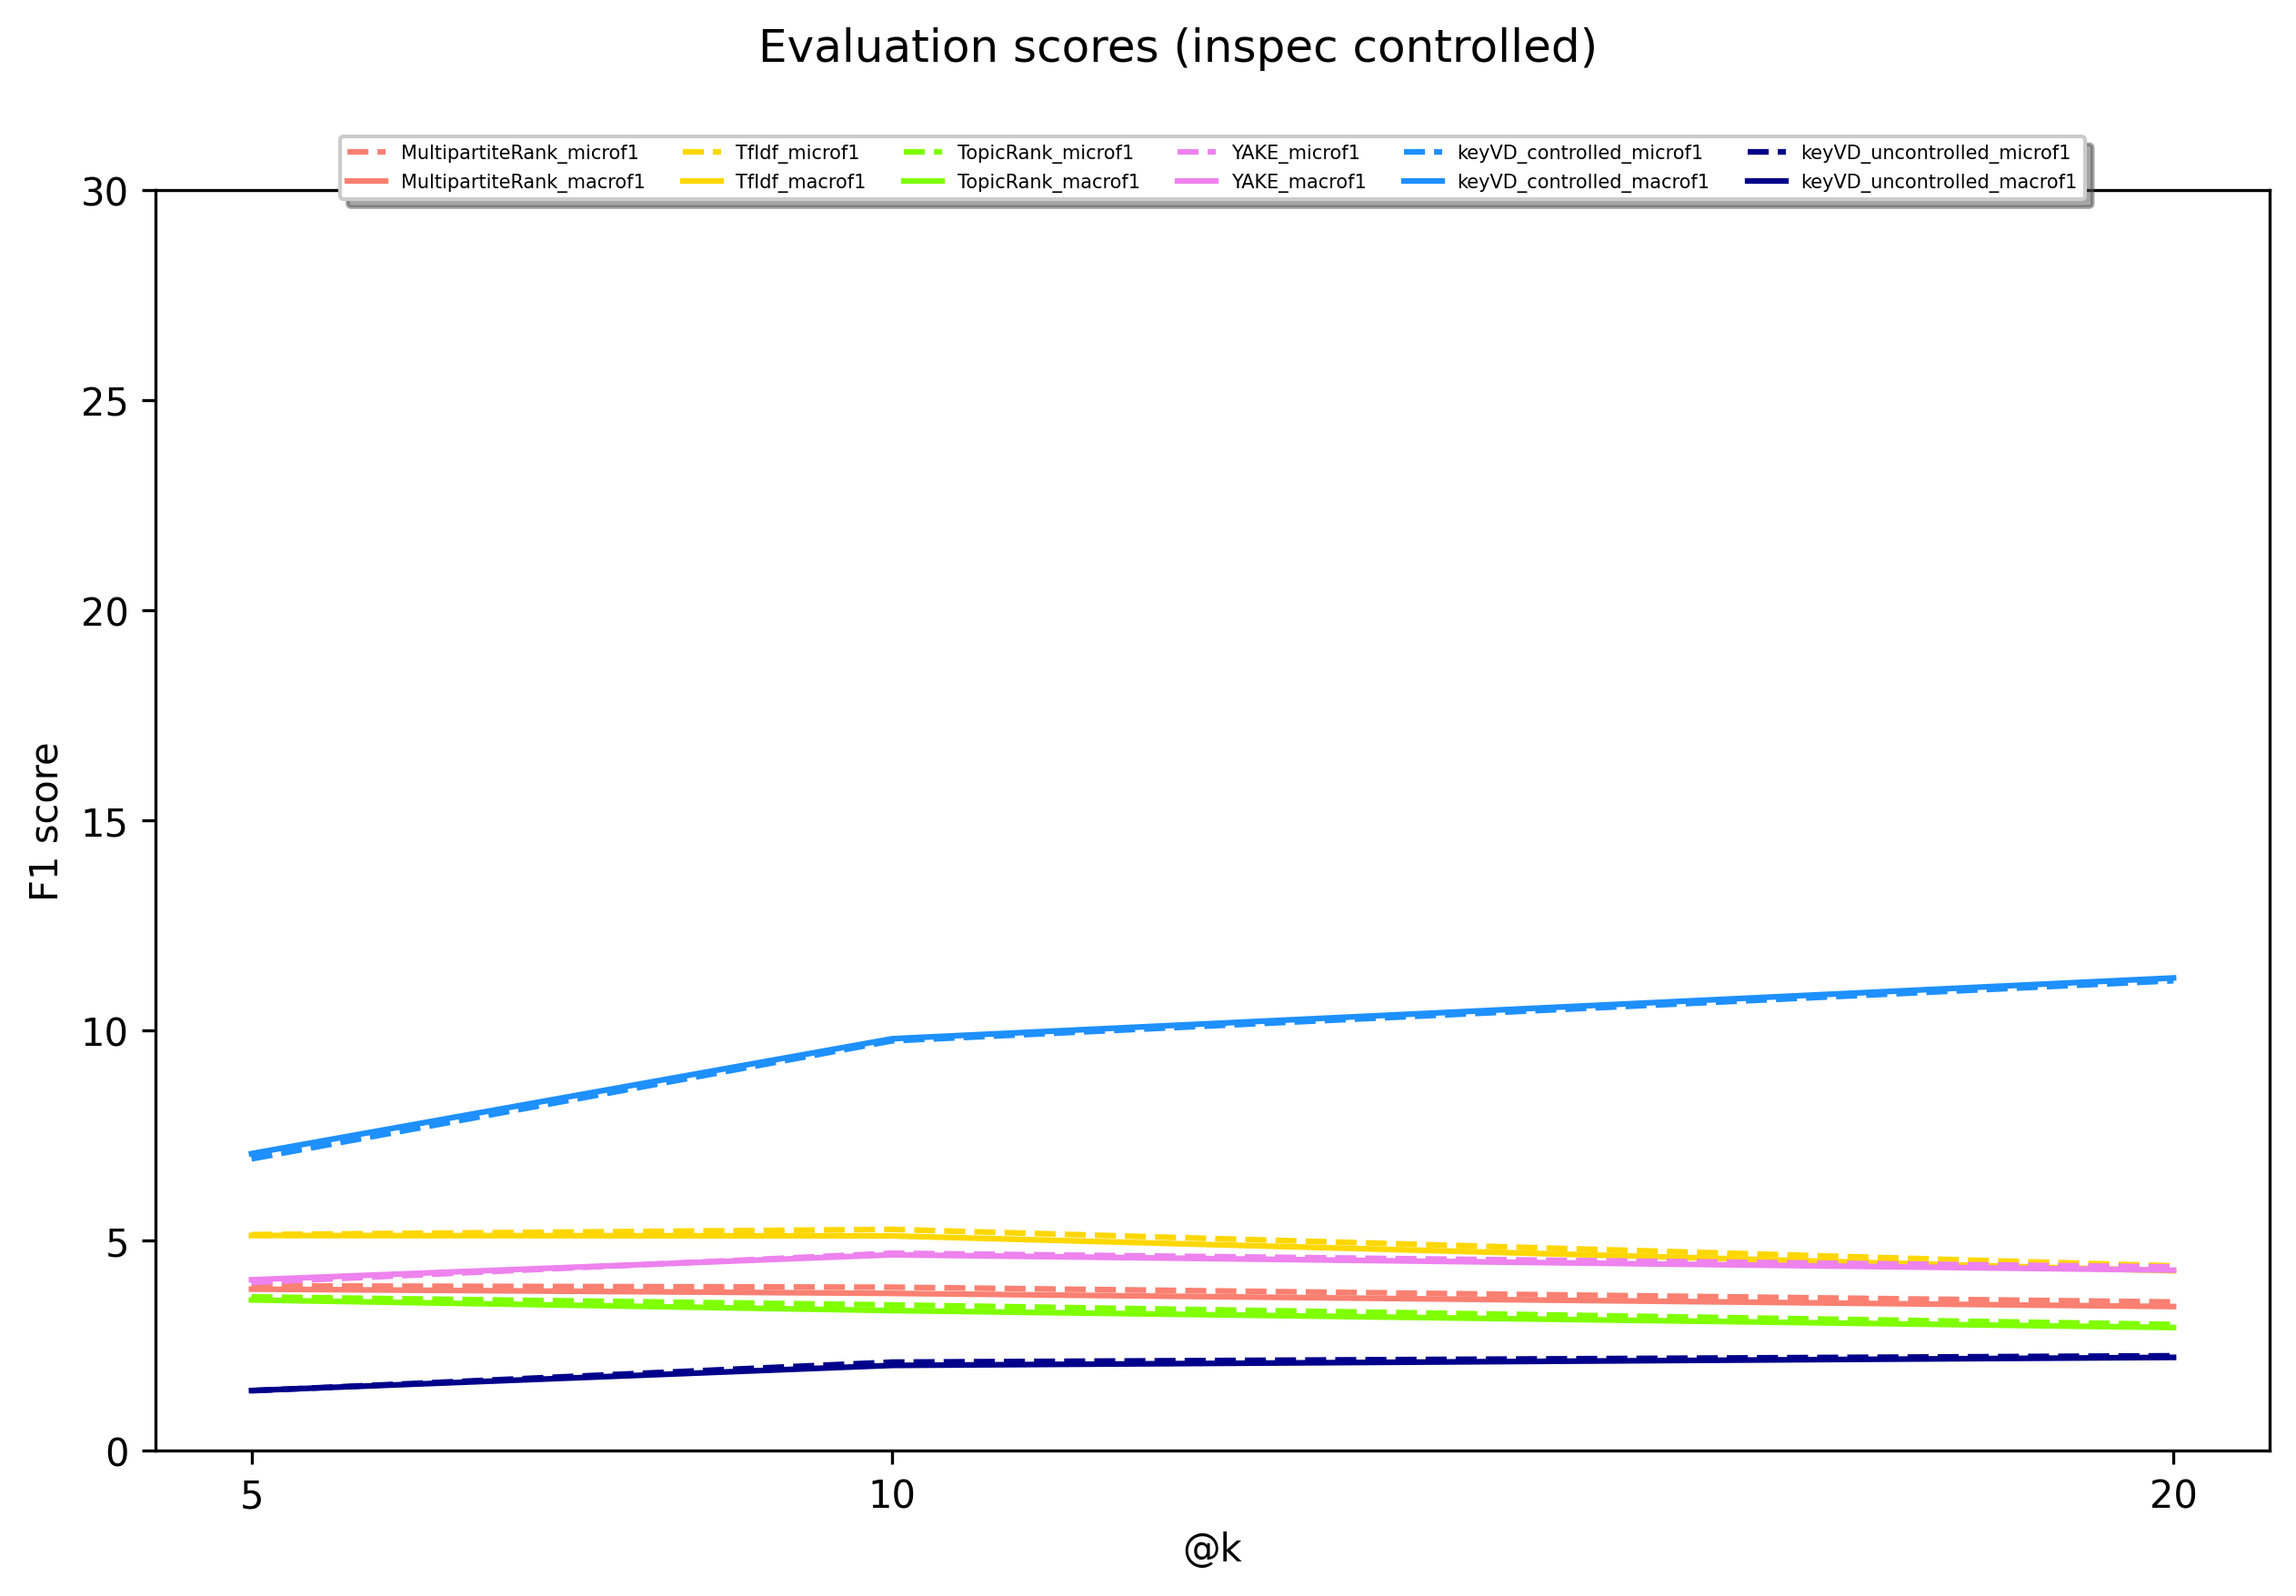

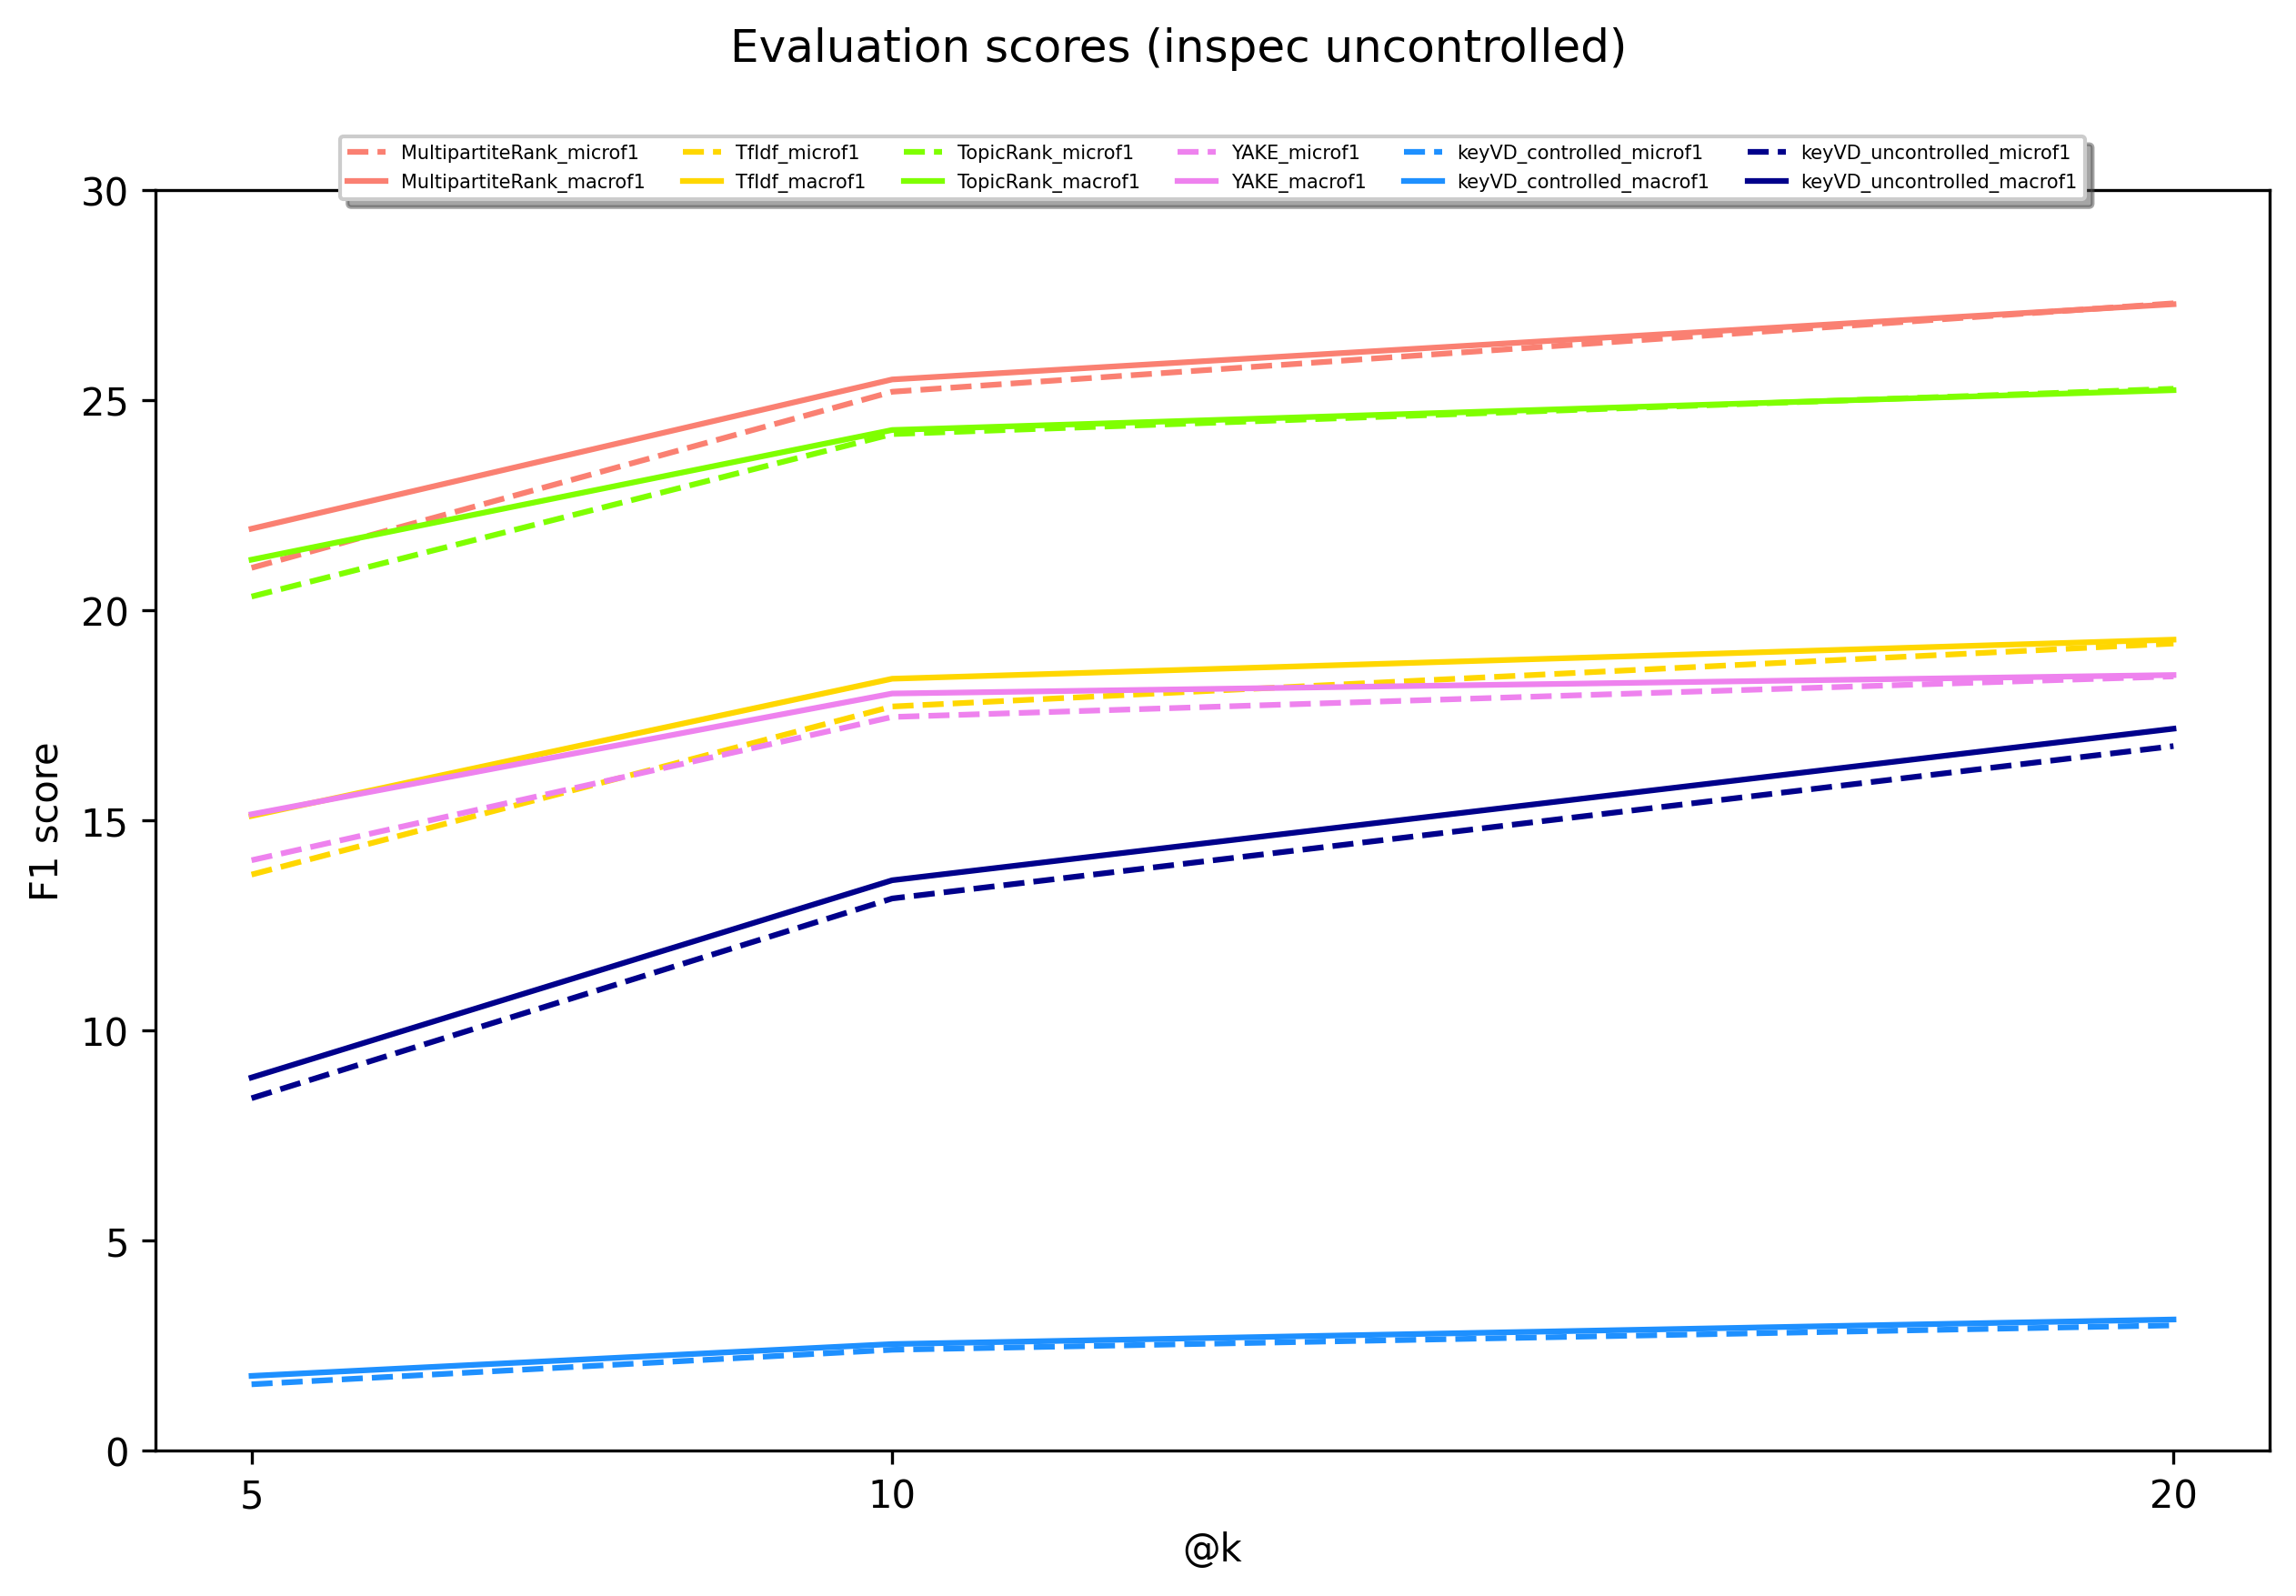

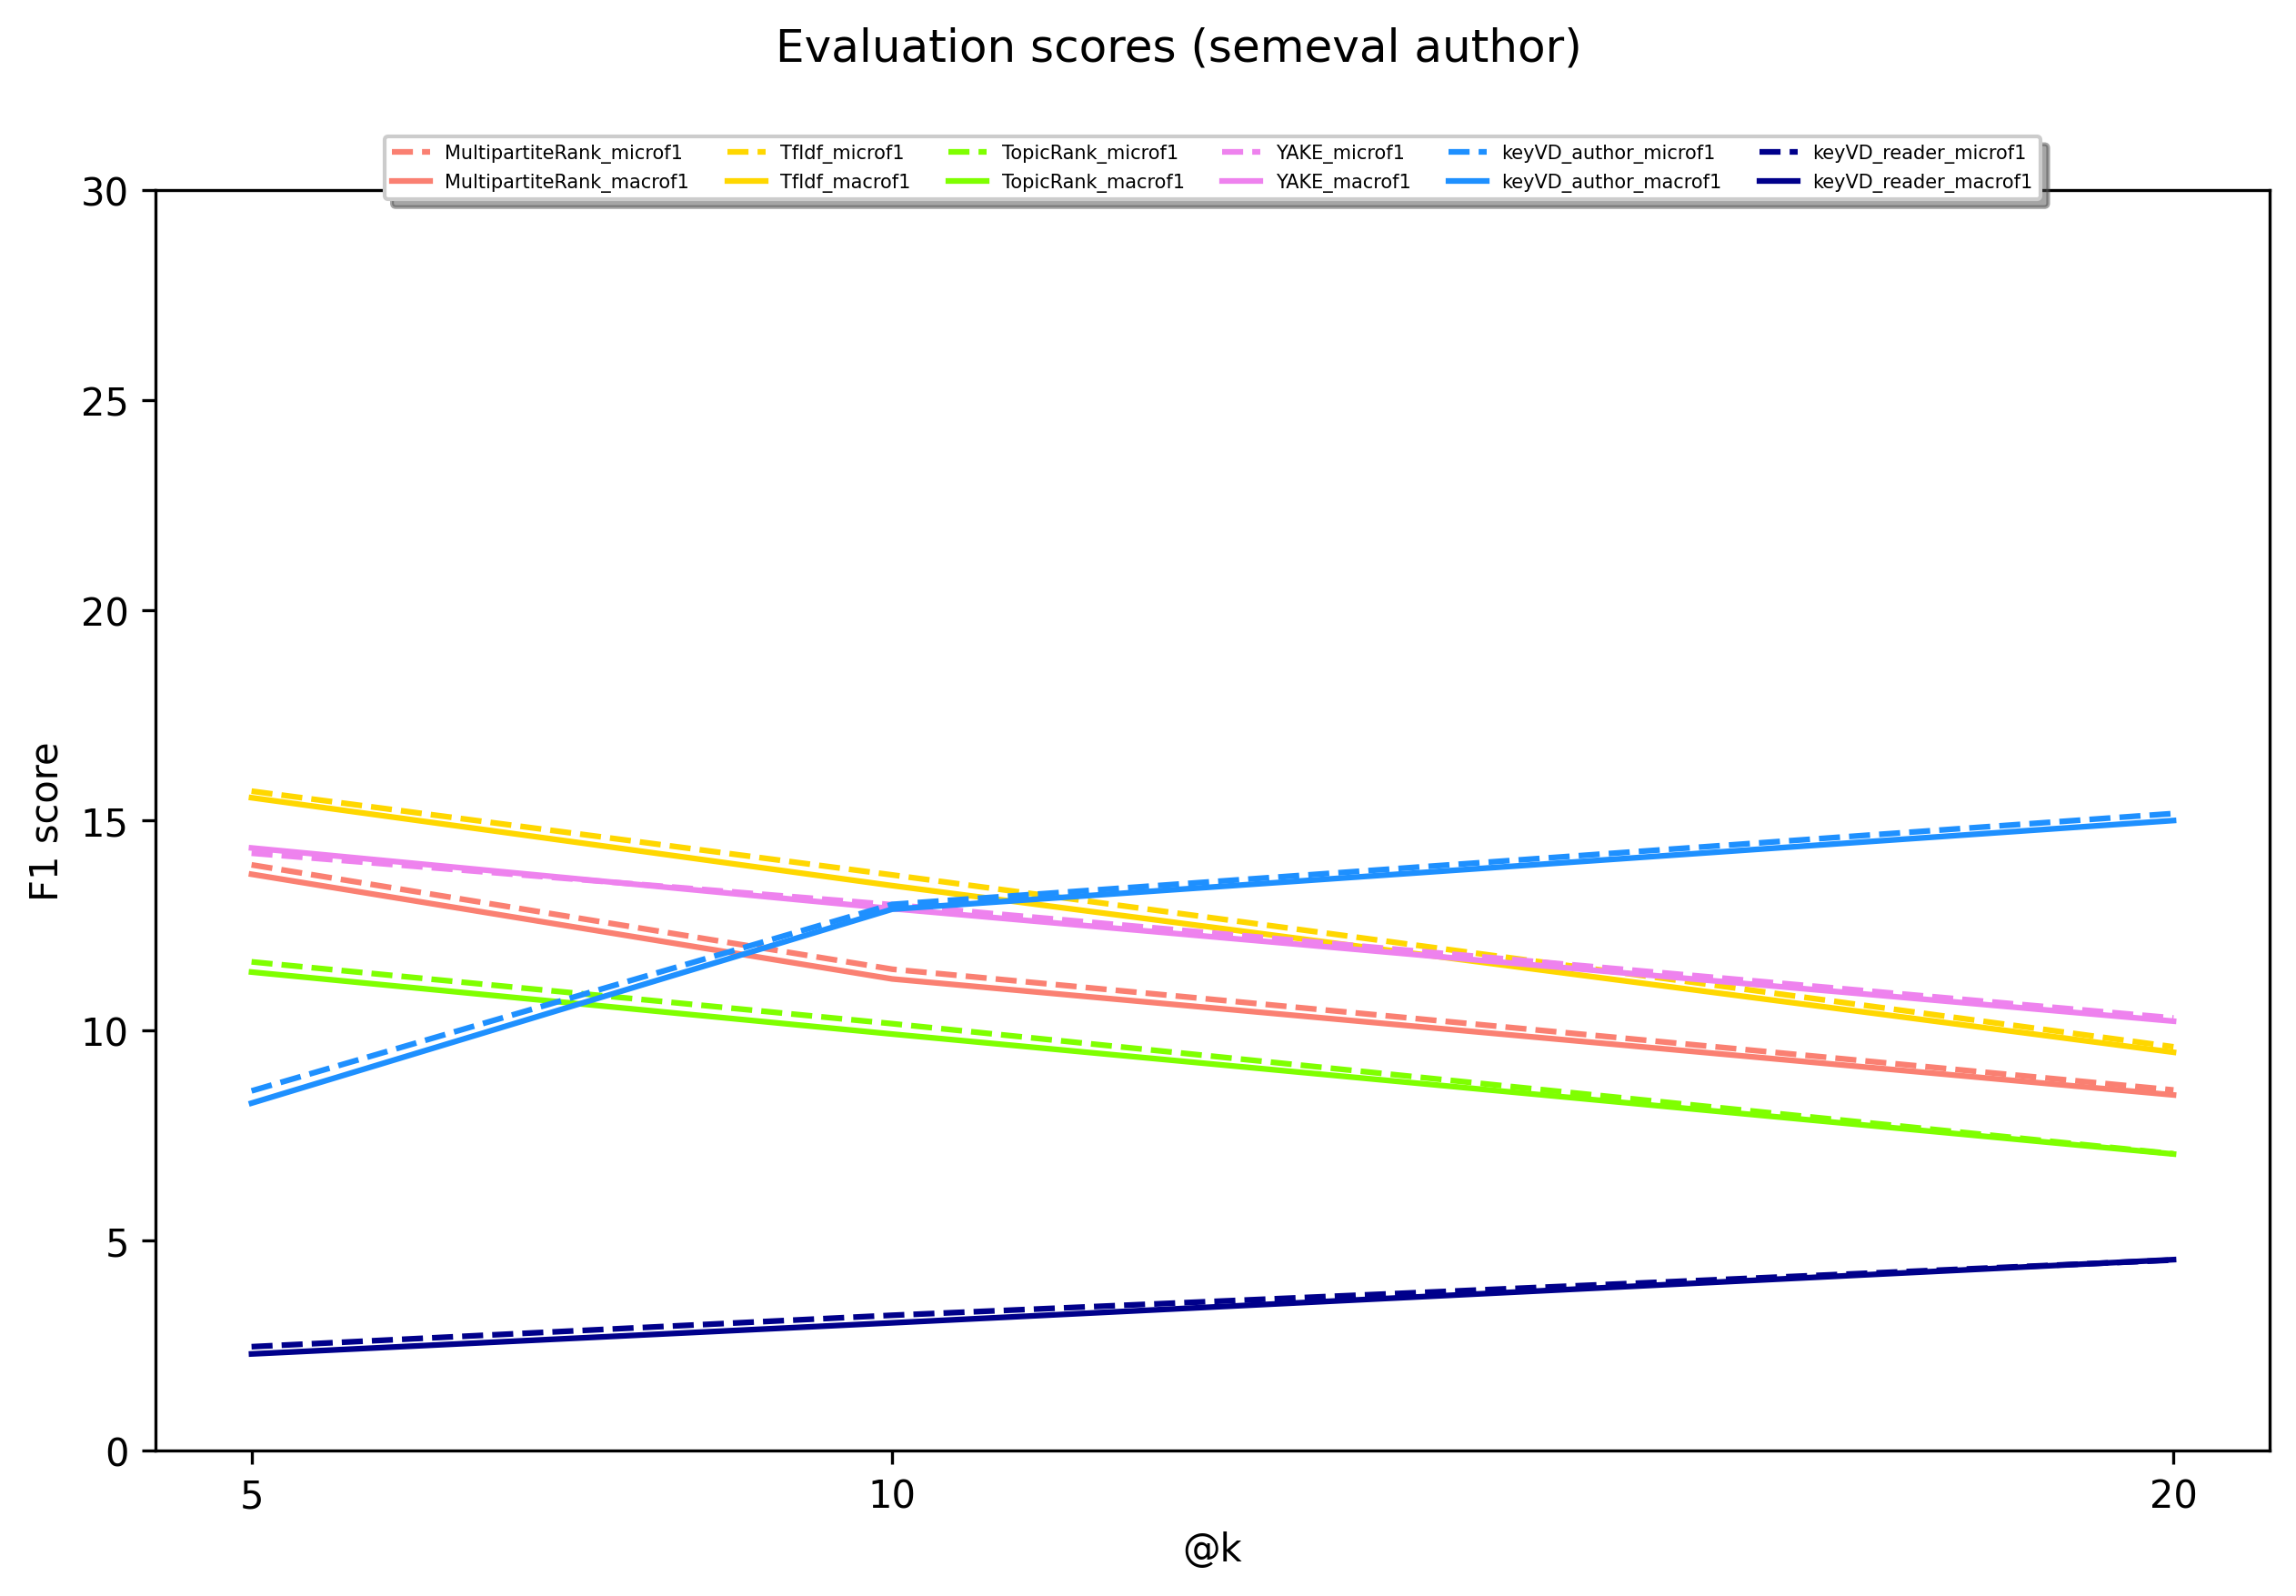

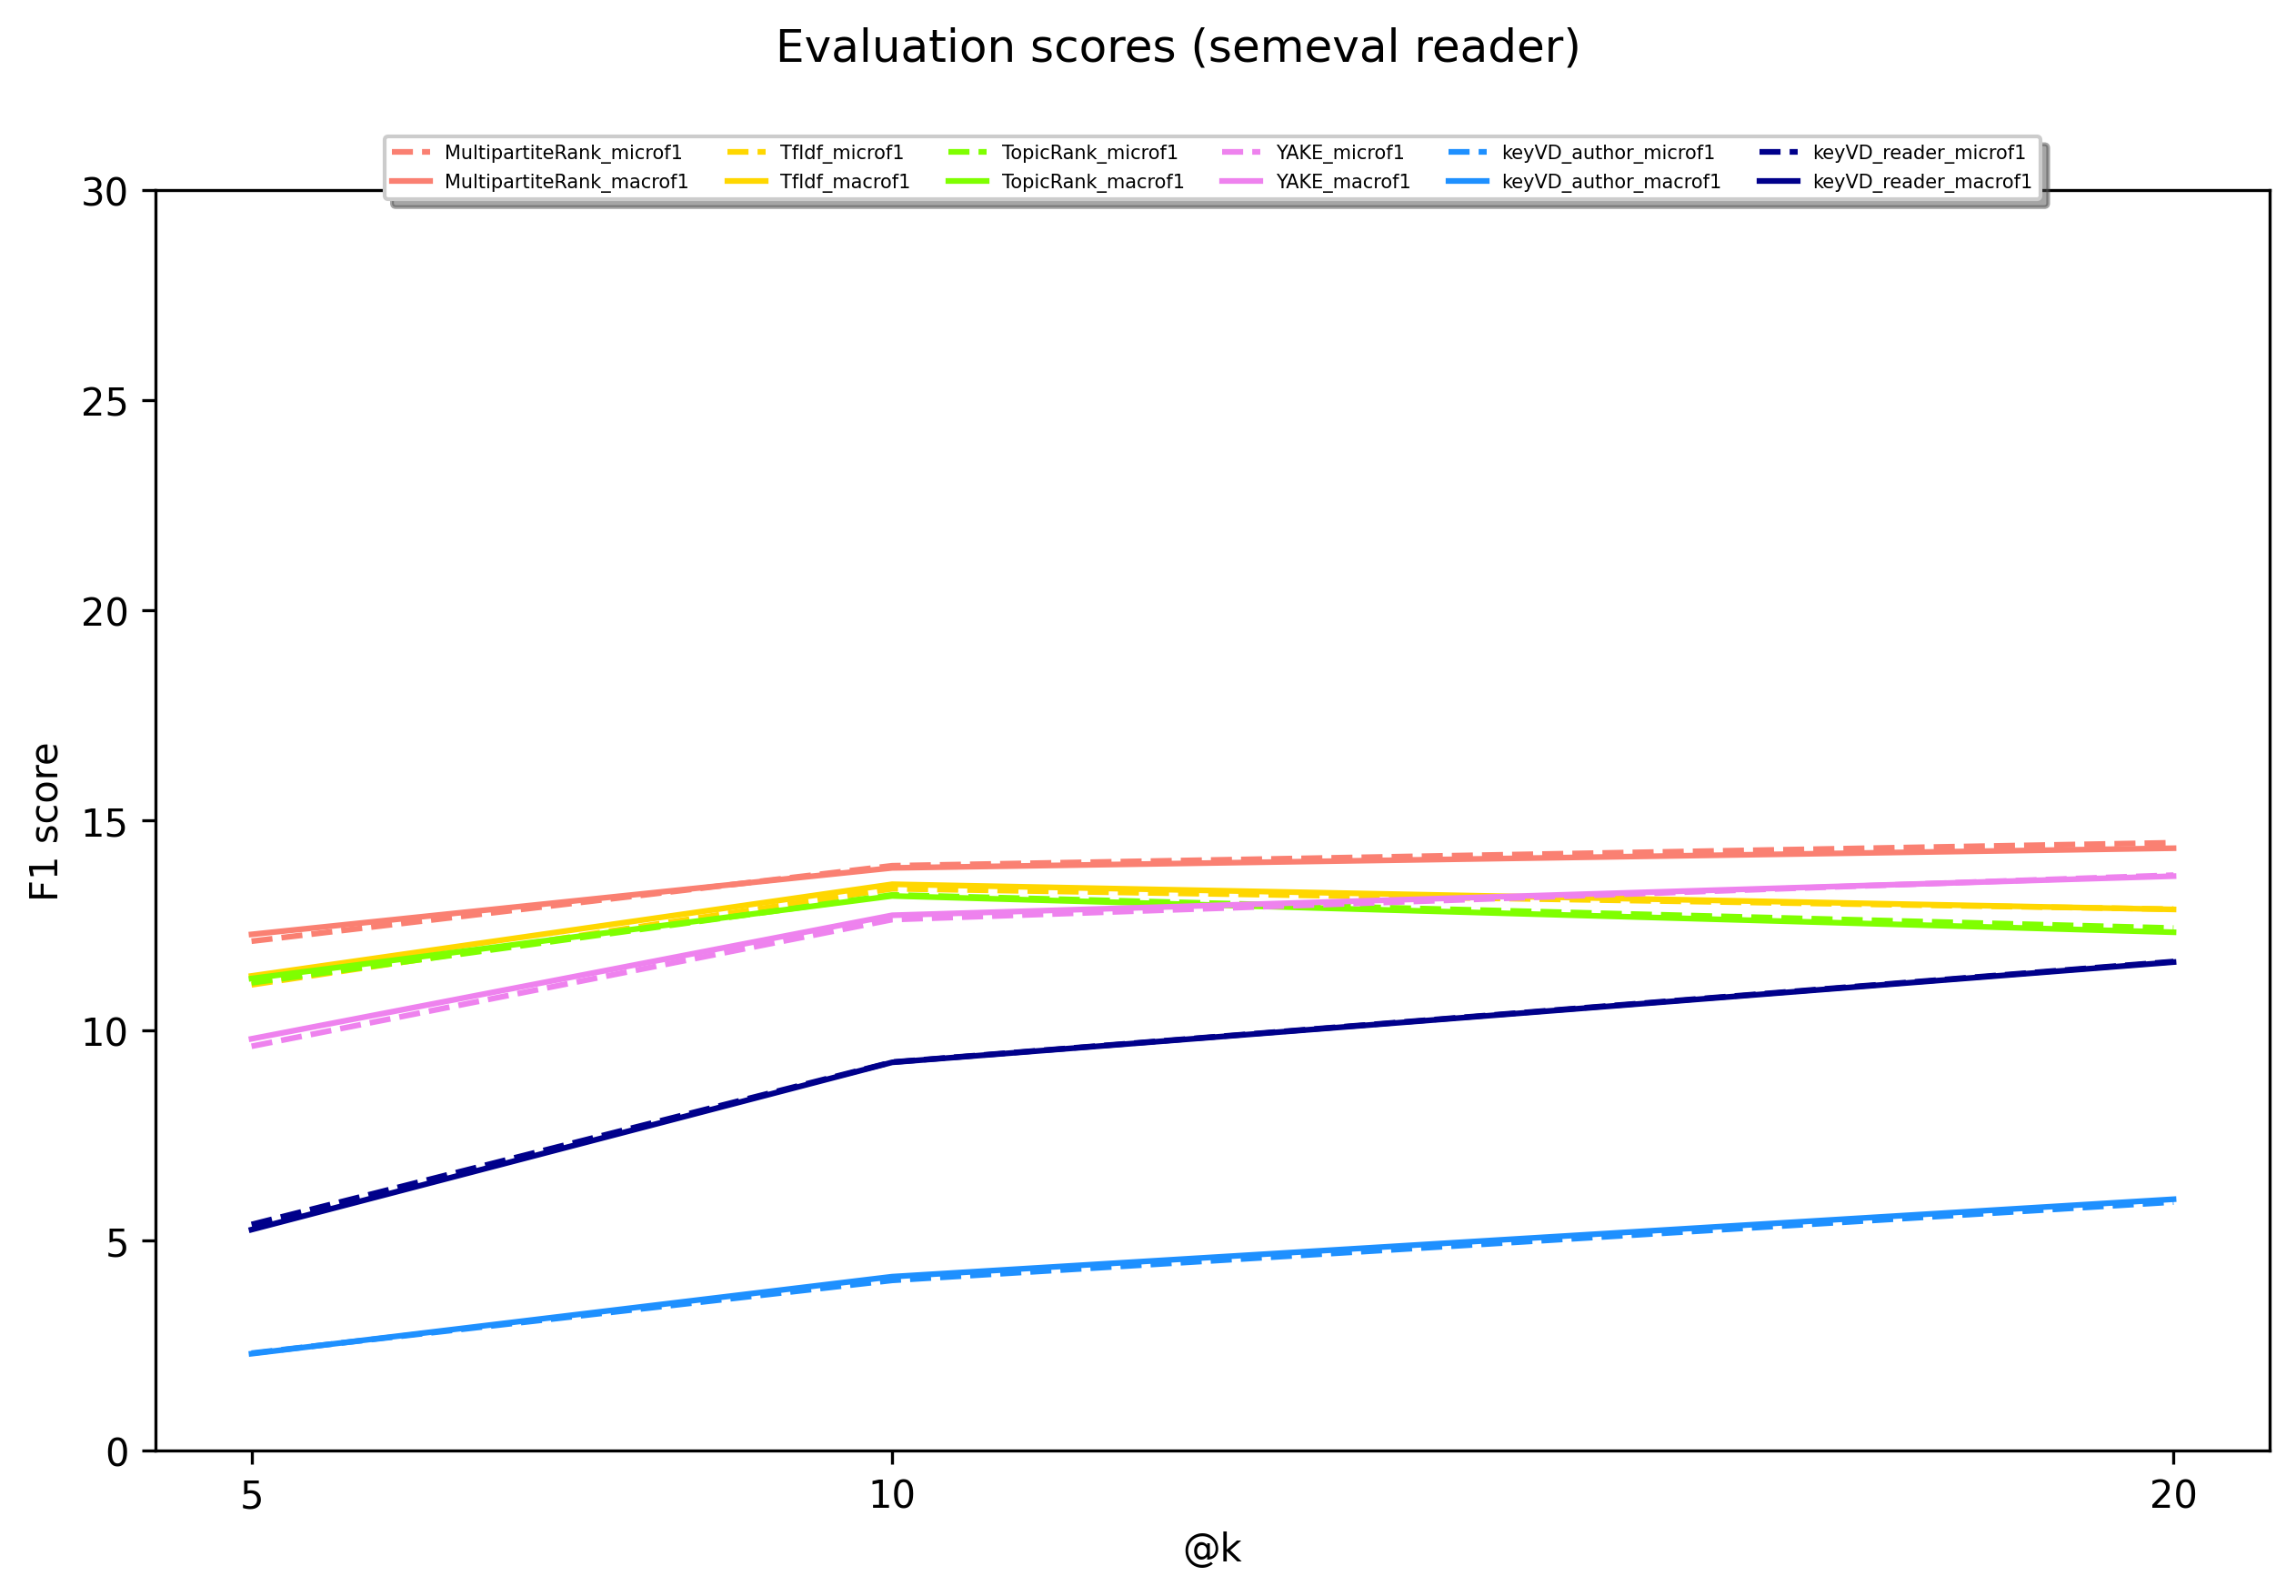

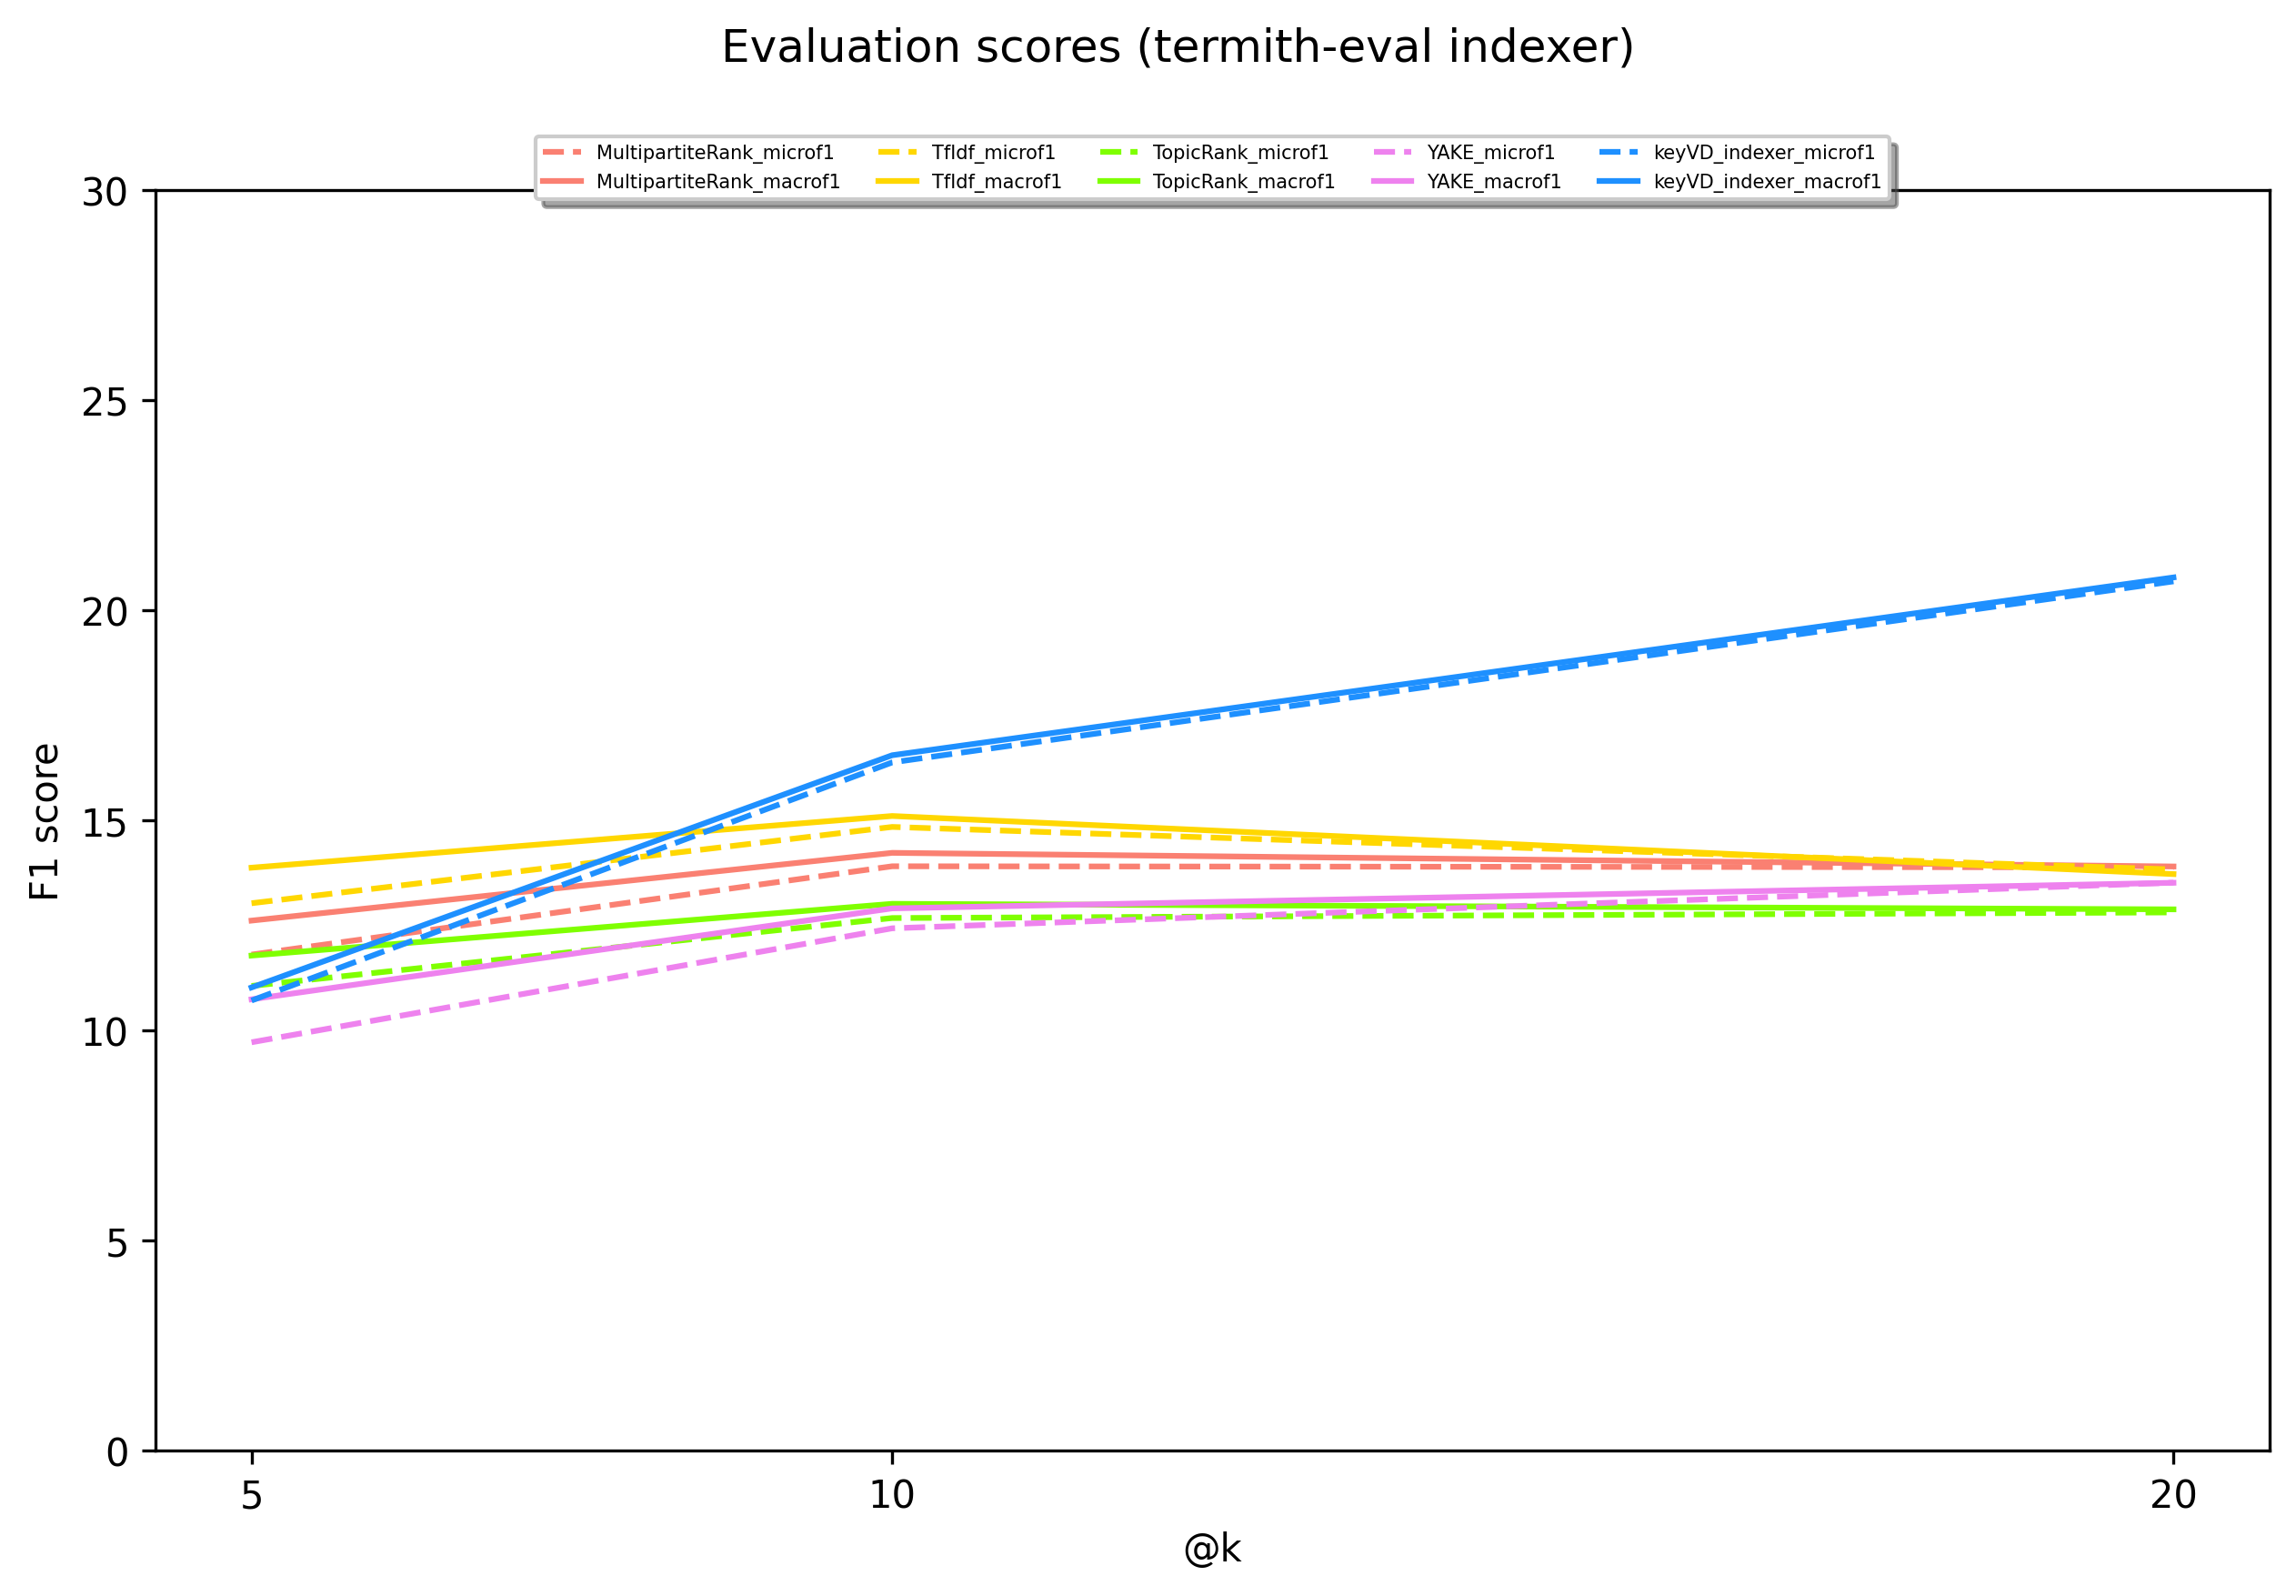

In [25]:
import matplotlib.pyplot as plt

plt.rcParams.update({'font.size': 10})
plt.rc('legend',fontsize=5)
colors = ['salmon', 'gold', 'chartreuse', 'violet', 'dodgerblue', 'darkblue']
graphs = results[[f'micf1_{top}' for top in tops] + [f'macf1_{top}' for top in tops]].reset_index()
datasets = ['inspec_controlled', 'inspec_uncontrolled', 'semeval_author', 'semeval_reader', 'termith-eval_indexer']

for _ in range(5):
    figure, axis = plt.subplots(nrows = 1, ncols = 1, figsize = (10, 6), dpi = 300)

    color = 0
    indexes = graphs.apply(lambda x : x['dataset_id'] + '_' + x['subset_id'] == datasets[_], axis = 1)
    for row in graphs[indexes].values:
        figure.suptitle('Evaluation scores (' + row[0] + ' ' + row[1] + ')')
        axis.plot(tops, row[3:3+len(tops)], linestyle = 'dashed', color = colors[color], label = f'{row[2]}_microf1')
        axis.plot(tops, row[3+len(tops):], color = colors[color], label = f'{row[2]}_macrof1')
        if _ == 4 :
            ncol=5
        else:
            ncol=6
        axis.legend(loc='upper center', bbox_to_anchor=(0.5, 1.05), ncol=ncol, fancybox=True, shadow=True)
        axis.set_ylim([0, 30])
        axis.set_xlabel('@k')
        axis.set_ylabel('F1 score')
        axis.set_xticks(tops)
        color += 1
        
    plt.show()